Write a program to estimate a depth map from a pair of calibrated images in Figure 4 using an MRF and graphcuts. The camera matrices are available here. Note that, for finding the epipolar lines using the provided camera matrices, you might want to use the following equation:

### camera metrices:
1221.2270770	0.0000000	479.5000000	
0.0000000	1221.2270770	269.5000000	
0.0000000	0.0000000	1.0000000	
1.0000000000	0.0000000000	0.0000000000	
0.0000000000	1.0000000000	0.0000000000	
0.0000000000	0.0000000000	1.0000000000	
0.0000000000	0.0000000000	0.0000000000	


1221.2270770	0.0000000	479.5000000	
0.0000000	1221.2270770	269.5000000	
0.0000000	0.0000000	1.0000000	
0.9998813487	0.0148994942	0.0039106989	
-0.0148907594	0.9998865876	-0.0022532664	
-0.0039438279	0.0021947658	0.9999898146	
-9.9909793759	0.2451742154	0.1650832670	

In [1]:
import numpy
import math
import cv2
from gco import pygco
import matplotlib.pyplot as plt
import matplotlib.image
import typing
import functools


/Users/admin/EE5371/CA2/.venv/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


In [2]:
# @cache
def compute_distance(point1: numpy.ndarray, point2: numpy.ndarray) -> float:
    """
    compute distance of two pixels
    Parameters
    ----------
    point1: ndarray, uint8, shape=(3)
        point one
    point2: ndarray, uint8, shape=(3)
        point two
    """
    # return (abs(point1[0]-point2[0]) + abs(point1[1] - point2[1]) + abs(point1[2] - point2[2]) ) / 3 / 255
    # if not dividing 255 as the C pseudocode example, there will be a overflowing of MAX_VALUE of Integer when calling pycgo.cut_grid_graph
    return numpy.sum(numpy.abs(point1.astype(int)-point2.astype(int))) / 20


In [3]:
K1: numpy.mat = numpy.mat(data=[[1221.2270770,0,479.5],[0,1221.2270770,269.5],[0,0,1]])
R1: numpy.mat = numpy.mat(data=[[1,0,0],[0,1,0],[0,0,1]])
T1: numpy.mat = numpy.mat(data=[0,0,0]).T
K2: numpy.mat = numpy.mat(data=[[1221.2270770,0,479.5],[0,1221.227077,269.5],[0,0,1]])
R2: numpy.mat = numpy.mat(data=[[0.9998813487,0.0148994942,0.0039106989],[-0.0148907594,0.9998865876,-0.0022532664],[-0.0039438279,0.0021947658,0.9999898146]])
T2: numpy.mat = numpy.mat(data=[-9.9909793759,0.2451742154,0.1650832670]).T
K1_inv: numpy.mat =  numpy.mat(data=numpy.linalg.inv(K1))

point_part_matrice = K2 @ R2.T @ R1 @ K1_inv
epipolar_line_matrice = K2 @ R2.T @ (T1-T2)

img1: numpy.ndarray = cv2.imread("data/part3_1.jpeg", cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
height1, width1, _ = img1.shape

img2: numpy.ndarray = cv2.imread("data/part3_2.jpeg", cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img2 = cv2.resize(img2, (width1, height1))

height2, width2, _ = img2.shape

In [4]:
POINT_COUNT_THRETHOD = 0.9
def compute_approximate_disparity_max(img1: numpy.ndarray, img2: numpy.ndarray) -> float:
    """
    approximate according to the number of count pixels after projection
    based on SIFT to find the overlapping rate
    """
    total_pixel = img1.shape[0] * img1.shape[1]
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT().create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    points1 = numpy.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = numpy.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    F, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC)

    overlap_ratio = numpy.sum(mask) / len(mask)
    target_count = overlap_ratio * POINT_COUNT_THRETHOD * total_pixel
    d_max = 10
    d_min = 0
    cur_count = 0
    loop_count = 0
    cur_height1, cur_width1, _ = img1.shape
    cur_height2, cur_width2, _ = img2.shape
    while cur_count < target_count or loop_count < 50:
        print(f"d_max:{d_max}")
        print(f"loop_count:{loop_count}")

        loop_count += 1
        cur_count = 0
        epipolar_line = d_max * epipolar_line_matrice
        for y1 in range(cur_height1):
            for x1 in range(cur_width1):
                xh1 = numpy.mat(data=[x1,y1, 1])
                xh2 = (point_part_matrice @ xh1.T) + epipolar_line
                x2, y2, scale = xh2
                y2 = int(y2/scale)
                x2 = int(x2/scale)
                if 0 <= y2 < cur_height2 and 0 <= x2 < cur_width2:
                    cur_count += 1
        print(f"cur_count:{cur_count}, target_count:{target_count}")
        if cur_count < target_count:
            gap = (d_max - d_min)
            d_max -= gap/2
        else:
            middle = (d_max + d_min) /2
            d_min = d_max
            d_max += middle
    return d_max
d_max = compute_approximate_disparity_max(img1=img1, img2=img2)
# print(f"d_max:{d_max}")


In [5]:

STEPS:typing.List[int] = [65]
SIGMA_C = 30
MAX_DIFF_COST = 0.0
@functools.cache
def compute_pc(difference: float) -> float:
    """
        Args:
            disparity: |It(x) - It'(ltt'(x,d))| >=0
    """
    return SIGMA_C / (SIGMA_C + difference)

print(f"point_part_matrice:{point_part_matrice}")
tem_cost = []
unary_cost_dict = {}
for STEP in STEPS:
    depth_range = (d_max) / STEP
    unary_cost: numpy.ndarray = numpy.zeros(shape=(height1, width1, STEP))
    for s in range(STEP):
        d = (s +1) * depth_range
        epipolar_line = d * epipolar_line_matrice
        pre_epipolar_line = (d-depth_range) * epipolar_line_matrice
        for y1 in range(height1):
            for x1 in range(width1):
                xh1 = numpy.mat(data=[x1,y1, 1])
                xh2 = (point_part_matrice @ xh1.T) + epipolar_line
                x21, y21, scale = xh2
                y21 = int(y21/scale)
                x21 = int(x21/scale)
                if 0 <= y21 < height2 and  0 <= x21 < width2:
                    unary_cost[y1, x1, s] = compute_distance(point1=img1[y1,x1], point2=img2[y21, x21])
                else:
                    unary_cost[y1, x1, s] = MAX_DIFF_COST
    print(f"unary_cost:{unary_cost}")
    unary_cost_dict[STEP] = unary_cost


point_part_matrice:[[ 1.00141684e+00 -1.57754771e-02 -1.24907567e+00]
 [ 1.57625060e-02  9.99389337e-01 -4.71598561e+00]
 [ 3.20227006e-06 -1.84508389e-06  9.98951576e-01]]


/var/folders/f1/_b6gmc6s181cyttj1rzj61v40000gn/T/ipykernel_1004/2420564513.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y21 = int(y21/scale)
/var/folders/f1/_b6gmc6s181cyttj1rzj61v40000gn/T/ipykernel_1004/2420564513.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x21 = int(x21/scale)


unary_cost:[[[ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [15.05 16.85  0.   ...  0.    0.    0.  ]
  [16.85  8.35  0.   ...  0.    0.    0.  ]
  [ 8.35  0.    0.   ...  0.    0.    0.  ]]

 [[ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [20.1  16.4   0.   ...  0.    0.    0.  ]
  [16.4   4.25  0.   ...  0.    0.    0.  ]
  [ 4.25  0.    0.   ...  0.    0.    0.  ]]

 [[ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [18.65 15.7   0.   ...  0.    0.    0.  ]
  [15.7   3.85  0.   ...  0.    0.    0.  ]
  [ 3.85  0.    0.   ...  0.    0.    0.  ]]

 ...

 [[ 0.    0.    0.   ...  0.2   0.4   0.9 ]
  [ 0.    0.    0.   ...  0.25  1.15  0.3 ]
  [ 0.    0.    0.   ...  0.85  1.35  0.4 ]
  ...
  [ 0.    0.    0.   ...  0. 

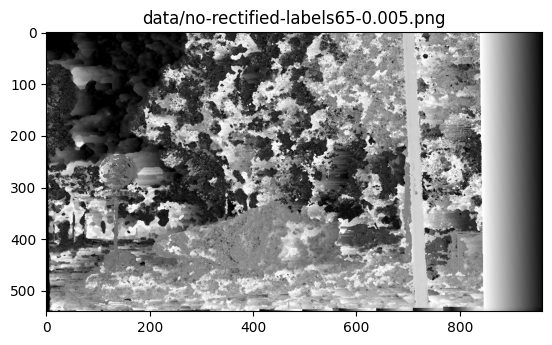

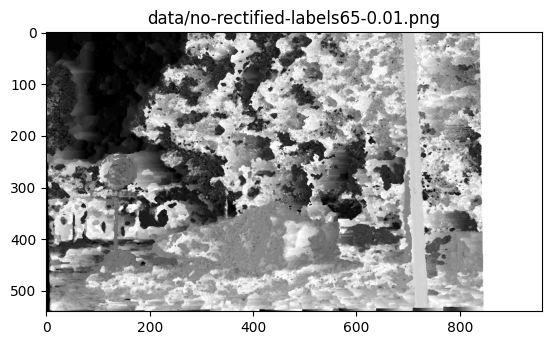

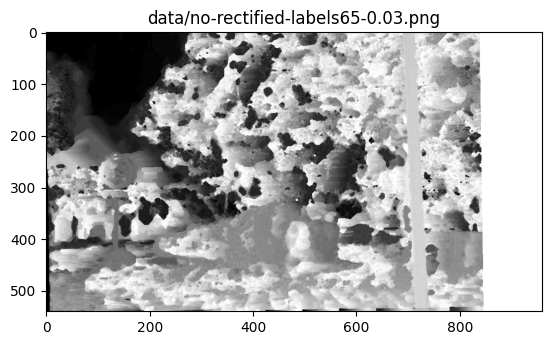

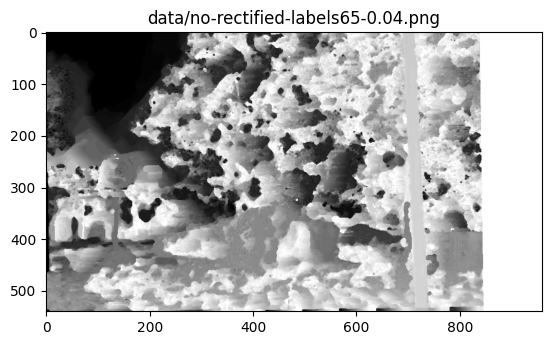

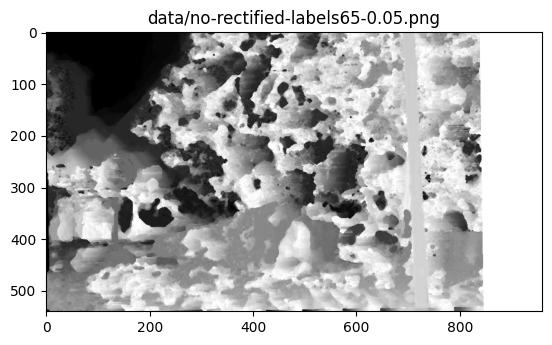

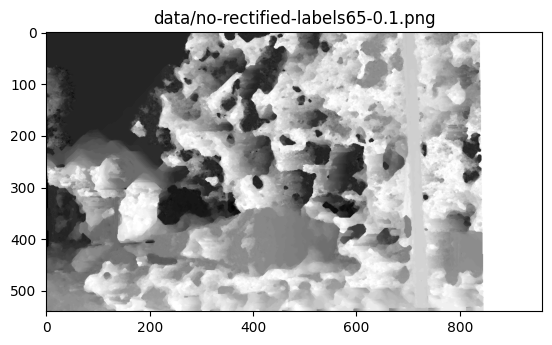

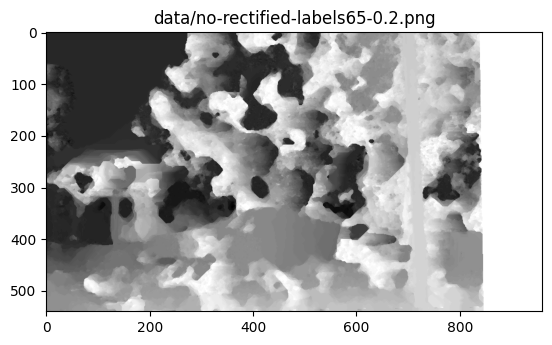

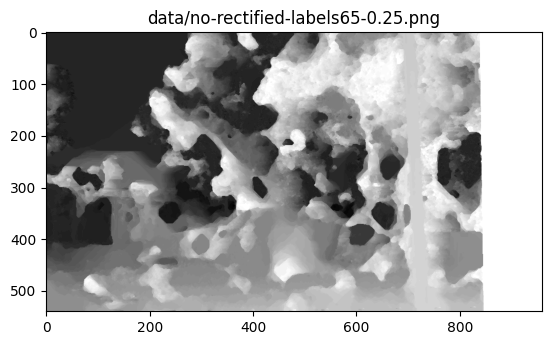

In [ ]:
for STEP in STEPS:
    # LAMBDA = 0.01
    # LAMBDAS = [0.005, 0.006, 0.007, 0.01,0.02,0.03, 0.04, 0.05, 0.06,0.07,0.08,0.09,0.10]
    # LAMBDAS = [0.05, 0.1, 0.2 ,0.3,0.4, 0.001,0.002,0.004,0.008,0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07,0.08,0.09,0.1,0.11, 0.12,0.13,0.14]
    LAMBDAS = [0.0001,0.0003,0.0004,0.005,0.006, 0.007, 0.008, 0.009, 0.01, 0.03,0.04,0.05, 0.1,0.2, 0.25, 0.3,0.35,0.4]
    
    unary_cost = unary_cost_dict[STEP]

    print(f"unary_cost:{unary_cost}")

    for lam in LAMBDAS:
        # lam/=10
        fp = numpy.zeros(shape=(STEP,STEP))
        for i in range(STEP):
            for j in range(STEP):
                if i!= j:
                    fp[i, j] = abs(i-j) * lam
        labels = pygco.cut_grid_graph_simple(unary_cost=unary_cost, pairwise_cost=fp, connect=8, algorithm="swap").reshape(height1,width1)
        labels = numpy.array(labels, dtype='uint8')
        img_path = f"data/no-rectified-labels{STEP}-{lam}.png"
        cv2.imwrite(filename=img_path, img=labels)
        origin_img = matplotlib.image.imread(f"data/no-rectified-labels{STEP}-{lam}.png")
        plt.imshow(origin_img, cmap='gray')
        plt.title(img_path)
        plt.show()


# Here is the best result by MRF and graphcuts
## it is generated under the following parameters:
### max_disparity 0.0089456(fluctuating each time it runs)
it is computed by compute_approximate_disparity_max method.
Firstly, used sift to generator descriptors of two imgs and then used knn to match. After matching, I utilized cv2.findFundamentalMat to get the overlapping mask of two images and get the overlapping rate.
Secondly, I adopted a binary search in optimizing the value of d_max to make sure most of pixels after projecting by epipolar Geometry are within the target image.
### fp piror term / smooth term
I used $\left| Dt(x) - Dt(y) \right|$. Dt(x) and Dt(y) are labels in practice.
### LAMBDA: the weighting value of fp 0.01

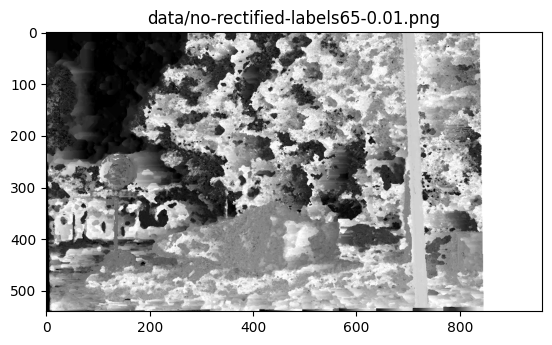